In [1]:
import os
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

np.set_printoptions(precision=2)

c:\users\czho9\anaconda3\envs\tsf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Configurable parameter
model_path = r'D:\capstone\model_save\InceptionV3_similar_7class_augmented_NB_IV3_LAYERS.h5'
model_val_dir = 'D:\capstone\dataset\Inat_2017_Extra\Aves_augmented_7class_vali'
# The size used during training
target_size = (299,299)
batch_size = 32
# Whether to normalize the confusion matrix or not
cf_norm = True

In [3]:
# Generated variable that might be quite heavy, load it only once
model = load_model(model_path)
class_labels = os.listdir(model_val_dir)
labels_to_num = {c:i for i,c in enumerate(class_labels)}

In [4]:
def generate_true_labels(test_dir):
    """
    Generating the list of true label for each validation image in order
    """
    true_labels = []
    for i,subdir in enumerate(os.listdir(test_dir)):
        true_labels += [i]*len(os.listdir(os.path.join(test_dir,subdir)))
    return np.array(true_labels)

true_labels = generate_true_labels(model_val_dir)

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
        model_val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False) # Must not be shuffled so it can be compared with the true labels

Found 1721 images belonging to 7 classes.


In [6]:
# List array of prediction probability for each class
# This cell is slow, don't rerun it unless necessary
predictions = model.predict_generator(validation_generator)

In [7]:
# Best prediction on each image
y_pred = np.argmax(predictions, axis=-1)

In [8]:
# Function from scikit learn example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

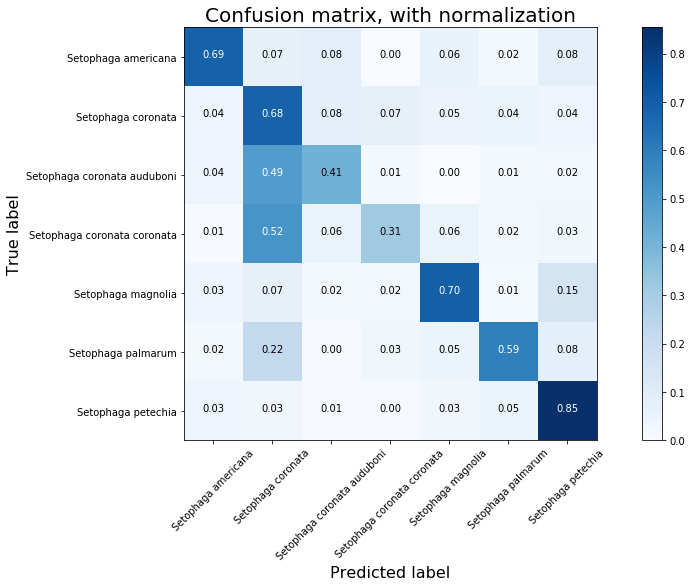

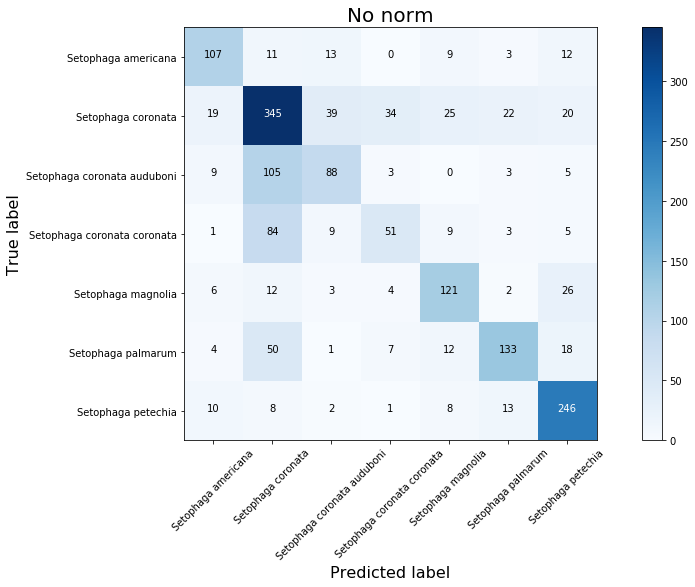

In [13]:
cnf_matrix = confusion_matrix(true_labels, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(13,8))
title = 'Confusion matrix, with normalization' if cf_norm else 'Confusion matrix, without normalization'
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      normalize=cf_norm,
                      title=title)
plt.figure(figsize=(13,8))
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      normalize=False,
                      title='No norm')

In [11]:
# Converting the classification report to dataframe
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
# Edited a bit to cater for the difference in format
# Can't really get the last row (avg / total) to a proper format, don't use it for now
def classifaction_report_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3] + lines[-2:-1]:
        row = {}
        row_data = line.split()
        row['class'] = ' '.join(row_data[:-4])
        row['precision'] = float(row_data[-4])
        row['recall'] = float(row_data[-3])
        row['f1_score'] = float(row_data[-2])
        row['support'] = int(row_data[-1])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.set_index(dataframe.columns[0], inplace=True)
    return dataframe

In [12]:
# Disable warning just for this
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    report = classification_report(true_labels, y_pred, target_names=class_labels)
    report_df = classifaction_report_df(report)
print(report)

                             precision    recall  f1-score   support

        Setophaga americana       0.69      0.69      0.69       155
         Setophaga coronata       0.56      0.68      0.62       504
Setophaga coronata auduboni       0.57      0.41      0.48       213
Setophaga coronata coronata       0.51      0.31      0.39       162
         Setophaga magnolia       0.66      0.70      0.68       174
         Setophaga palmarum       0.74      0.59      0.66       225
         Setophaga petechia       0.74      0.85      0.79       288

                avg / total       0.63      0.63      0.63      1721

